In [19]:
# ToDo use additional features
# Cluster transformed series

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pylab import rcParams
import calendar
from datetime import datetime, timedelta
from scipy.spatial.distance import cdist


from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


rcParams['figure.figsize'] = 16,4
df = pd.read_csv('database.csv', low_memory=False)
df.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


In [3]:
df = pd.read_csv('database.csv', low_memory=False)
df.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


In [4]:
states = df[['Year', 'Month', 'State', 'Incident']]
states = states.groupby(['Year', 'Month', 'State'], as_index=False)['Incident'].sum()

states['Date'] = states.apply(lambda row: '{}-{}'.format(row.Year, row.Month), axis=1)
states.reset_index()
states.Date = pd.to_datetime(states.Date, format='%Y-%B')
states = states[['State', 'Incident', 'Date']]

states.Date = pd.to_datetime(states.Date, format='%Y-%B')
states.reset_index()
# states = states.sort_values(['State', 'Date'], ascending=True)
states.head()

,State,Incident,Date
0,Alabama,72,1980-04-01
1,Alaska,4,1980-04-01
2,Arizona,106,1980-04-01
3,Arkansas,55,1980-04-01
4,California,3743,1980-04-01


In [5]:
states_total = df[['State', 'Incident']]
states_total = states_total.groupby(['State'],as_index=False).sum()
states_total.columns = ['State', 'Incident']
states_total = states_total.sort_values(['Incident'], ascending=[True])
states_list = list(states_total.State)
states_list[:5]

['North Dakota', 'Vermont', 'South Dakota', 'Montana', 'Wyoming']

In [6]:
idx = pd.date_range(datetime(1980, 1, 1), datetime(2014, 12, 31), freq=pd.tseries.offsets.DateOffset(months=1))

my_series = pd.DataFrame()
s = pd.pivot_table(states,index=["State", "Date"], values=["Incident"], aggfunc=[np.sum])

for i in range(0,51):
    state = states_list[i]
    x = s.query('State == ["{}"]'.format(state))
    x = x.reset_index()
    x = x.set_index(pd.DatetimeIndex(x['Date']))
    x = x[['sum']]
    x.columns = ['Incident']
    x = x.reindex(idx, fill_value=0)
    x = x.fillna(0)
    my_series[state] = pd.Series(x['Incident'].values)
    
my_series = my_series[:50]
my_series.head()

,North Dakota,Vermont,South Dakota,Montana,Wyoming,New Hampshire,Maine,Idaho,Delaware,Rhodes Island,...,Louisiana,District of Columbia,Maryland,Pennsylvania,Michigan,Texas,Illinois,California,New York,Florida
0,2,1,0,1,1,0,1,3,4,6,...,51,190,155,209,1144,1642,1885,2992,11586,438
1,2,1,1,1,3,1,6,3,30,3,...,258,120,215,381,714,2077,2690,2526,8145,283
2,2,0,0,0,3,0,0,1,2,3,...,426,91,188,491,804,3426,1872,2346,8125,385
3,0,0,0,4,2,5,2,3,5,6,...,149,105,159,545,692,1908,2887,3743,11356,272
4,3,0,2,2,1,1,4,1,1,1,...,333,153,295,576,1639,2065,3589,2854,10365,1143


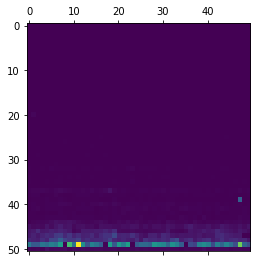

In [8]:
plt.matshow(my_series.T, interpolation=None, aspect='auto')
plt.show()

In [9]:
from dtw import dtw
def distance(x,y):
    return abs(x-y)

In [10]:
states = my_series.keys()
states

Index(['North Dakota', 'Vermont', 'South Dakota', 'Montana', 'Wyoming',
       'New Hampshire', 'Maine', 'Idaho', 'Delaware', 'Rhodes Island', 'Iowa',
       'Utah', 'Hawaii', 'Nebraska', 'Alaska', 'West Virginia', 'Kansas',
       'Oregon', 'Minnesota', 'Connecticut', 'New Mexico', 'Mississippi',
       'Washington', 'Arkansas', 'South Carolina', 'Massachusetts', 'Kentucky',
       'Colorado', 'Wisconsin', 'Nevada', 'Virginia', 'North Carolina',
       'New Jersey', 'Oklahoma', 'Alabama', 'Indiana', 'Arizona', 'Ohio',
       'Georgia', 'Tennessee', 'Missouri', 'Louisiana', 'District of Columbia',
       'Maryland', 'Pennsylvania', 'Michigan', 'Texas', 'Illinois',
       'California', 'New York', 'Florida'],
      dtype='object')

In [11]:
%%time
l = len(states)
dd1 = [ [ (dtw(my_series[states[x]],my_series[states[y]],distance)[0] if y > x else -1)  for y in range(l) ] 
       for x in range(l) ]
dd1

CPU times: user 43 s, sys: 4 ms, total: 43.1 s
Wall time: 43 s


In [13]:
dd2 = [ [ (dd1[x][y] if y > x else dd1[y][x])  for y in range(l) ] for x in range(l) ]
dd2

[[-1,
  0.25,
  0.28000000000000003,
  0.46999999999999997,
  0.59999999999999998,
  0.53000000000000003,
  0.65000000000000002,
  0.59999999999999998,
  1.3600000000000001,
  1.21,
  2.23,
  1.9099999999999999,
  4.5300000000000002,
  2.0299999999999998,
  4.0099999999999998,
  4.3799999999999999,
  10.17,
  10.43,
  4.9000000000000004,
  10.18,
  10.029999999999999,
  14.51,
  15.539999999999999,
  11.869999999999999,
  18.829999999999998,
  25.699999999999999,
  21.469999999999999,
  23.719999999999999,
  13.199999999999999,
  20.75,
  31.59,
  33.0,
  62.640000000000001,
  27.649999999999999,
  39.640000000000001,
  39.5,
  28.949999999999999,
  158.44999999999999,
  73.859999999999999,
  142.62,
  129.69,
  129.09,
  80.120000000000005,
  116.45,
  291.98000000000002,
  590.20000000000005,
  820.53999999999996,
  1323.1099999999999,
  1794.97,
  5474.1499999999996,
  266.89999999999998],
 [0.25,
  -1,
  0.31,
  0.45000000000000001,
  0.71999999999999997,
  0.5,
  0.760000000000000

In [14]:
for i in range(l):
    dd2[i][i] = 0.0
dd2

[[0.0,
  0.25,
  0.28000000000000003,
  0.46999999999999997,
  0.59999999999999998,
  0.53000000000000003,
  0.65000000000000002,
  0.59999999999999998,
  1.3600000000000001,
  1.21,
  2.23,
  1.9099999999999999,
  4.5300000000000002,
  2.0299999999999998,
  4.0099999999999998,
  4.3799999999999999,
  10.17,
  10.43,
  4.9000000000000004,
  10.18,
  10.029999999999999,
  14.51,
  15.539999999999999,
  11.869999999999999,
  18.829999999999998,
  25.699999999999999,
  21.469999999999999,
  23.719999999999999,
  13.199999999999999,
  20.75,
  31.59,
  33.0,
  62.640000000000001,
  27.649999999999999,
  39.640000000000001,
  39.5,
  28.949999999999999,
  158.44999999999999,
  73.859999999999999,
  142.62,
  129.69,
  129.09,
  80.120000000000005,
  116.45,
  291.98000000000002,
  590.20000000000005,
  820.53999999999996,
  1323.1099999999999,
  1794.97,
  5474.1499999999996,
  266.89999999999998],
 [0.25,
  0.0,
  0.31,
  0.45000000000000001,
  0.71999999999999997,
  0.5,
  0.7600000000000

In [29]:
len(dd2)

51

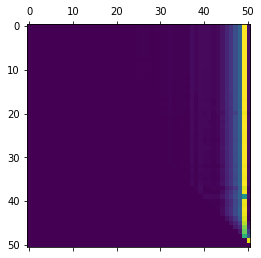

In [30]:
plt.matshow(dd1, interpolation=None, aspect='auto')
plt.show()

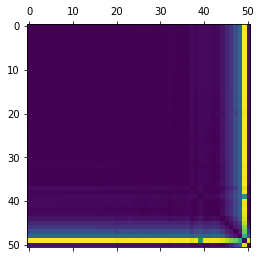

In [17]:
plt.matshow(dd2, interpolation=None, aspect='auto')
plt.show()

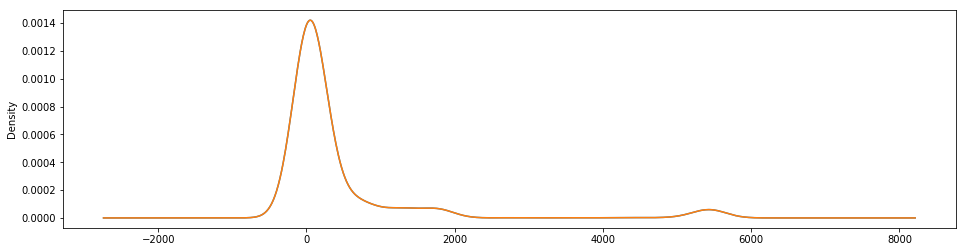

In [22]:
from pandas import Series
Series(np.reshape(dd2,(1,51*51))[0]).plot(kind='kde')
plt.show()

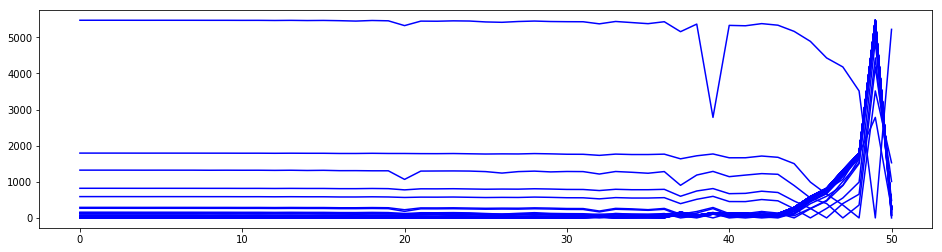

In [32]:
for sims in dd2[0:51]:
    plt.plot(sims,'b-')
plt.show()

In [53]:
from scipy.stats import itemfreq

db = DBSCAN(eps=0.42, min_samples=2, metric='precomputed').fit(dd2)
db.labels_

array([ 0,  0,  0,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [54]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print(itemfreq(db.labels_))

from operator import itemgetter
sorted(zip(states,db.labels_),key=itemgetter(1))

Estimated number of clusters: 2
[[-1 46]
 [ 0  3]
 [ 1  2]]


[('New Hampshire', -1),
 ('Maine', -1),
 ('Idaho', -1),
 ('Delaware', -1),
 ('Rhodes Island', -1),
 ('Iowa', -1),
 ('Utah', -1),
 ('Hawaii', -1),
 ('Nebraska', -1),
 ('Alaska', -1),
 ('West Virginia', -1),
 ('Kansas', -1),
 ('Oregon', -1),
 ('Minnesota', -1),
 ('Connecticut', -1),
 ('New Mexico', -1),
 ('Mississippi', -1),
 ('Washington', -1),
 ('Arkansas', -1),
 ('South Carolina', -1),
 ('Massachusetts', -1),
 ('Kentucky', -1),
 ('Colorado', -1),
 ('Wisconsin', -1),
 ('Nevada', -1),
 ('Virginia', -1),
 ('North Carolina', -1),
 ('New Jersey', -1),
 ('Oklahoma', -1),
 ('Alabama', -1),
 ('Indiana', -1),
 ('Arizona', -1),
 ('Ohio', -1),
 ('Georgia', -1),
 ('Tennessee', -1),
 ('Missouri', -1),
 ('Louisiana', -1),
 ('District of Columbia', -1),
 ('Maryland', -1),
 ('Pennsylvania', -1),
 ('Michigan', -1),
 ('Texas', -1),
 ('Illinois', -1),
 ('California', -1),
 ('New York', -1),
 ('Florida', -1),
 ('North Dakota', 0),
 ('Vermont', 0),
 ('South Dakota', 0),
 ('Montana', 1),
 ('Wyoming', 1)]

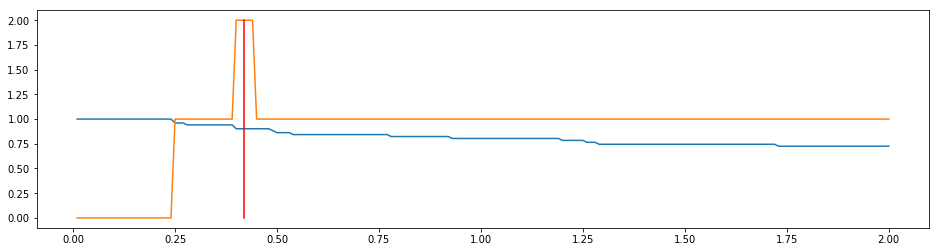

In [55]:
eps_list = np.linspace(0.01, 2.0, num=200)
#eps_list = np.linspace(0.78,0.8,num=200)
noise_list = np.array([])
n_clusters_list = np.array([])
for myeps in eps_list:
    db = DBSCAN(myeps, min_samples=2, metric='precomputed').fit(dd2)
    noise_list = np.append(noise_list, sum([ 1 if i==-1 else 0 for i in db.labels_]))
    n_clusters_list = np.append(n_clusters_list, len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
plt.plot(eps_list, noise_list/51)
plt.plot(eps_list, n_clusters_list)
plt.plot([0.42, 0.42], [0, 2],'r-')
plt.show()

Stress value:  6779344.68348


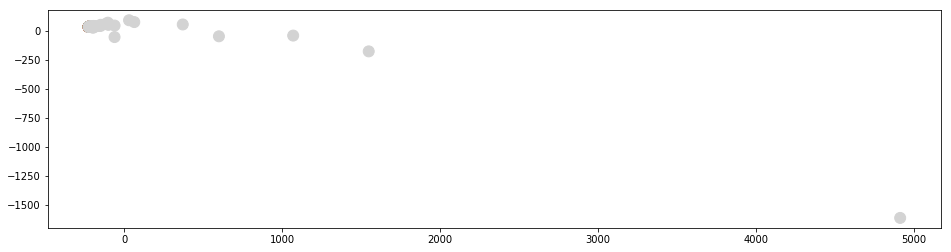

In [62]:
from sklearn import manifold
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(dd2)
print ("Stress value: ", pos.stress_)

# Assign colors based on clusters
db = DBSCAN(eps=0.42, min_samples=2, metric='precomputed').fit(dd2)
cols = ['lightgray', 'red', 'green', 'orange', 'blue']
cc = [ cols[l+1] for l in db.labels_]
plt.scatter(pos.embedding_.T[0], pos.embedding_.T[1], color=cc, s=120)
plt.show()

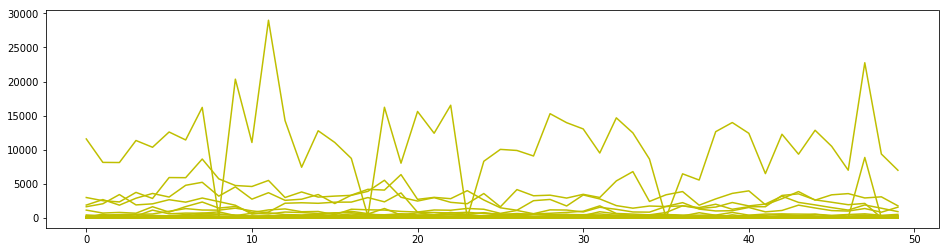

In [64]:
for i in range(len(db.labels_)):
    plt.plot(my_series[states[i]],'y-')
plt.show()

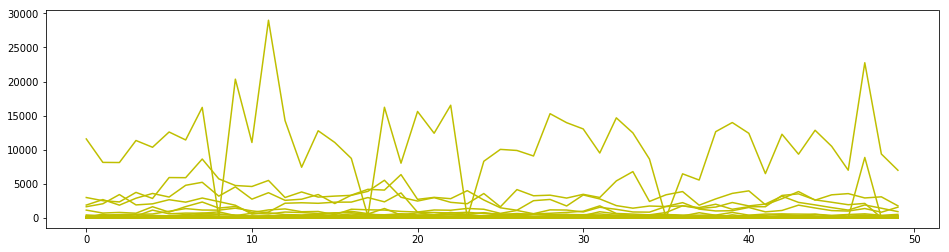

In [67]:
for i in range(len(db.labels_)):
    plt.plot(my_series[states[i]],'r-' if db.labels_[i]==0 else 'y-')
plt.show()

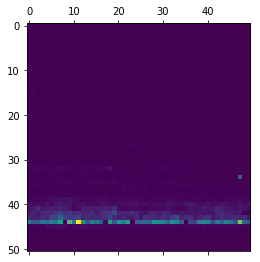

In [69]:
my_series_sort=sorted(zip(np.array(my_series.T),db.labels_),key=itemgetter(1))
my_series_sort2=[el[0] for el in my_series_sort]
plt.matshow(my_series_sort2, interpolation=None, aspect='auto')
plt.show()

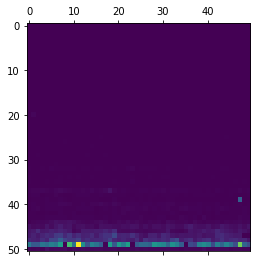

In [71]:
plt.matshow(my_series.T, interpolation=None, aspect='auto')
plt.show()

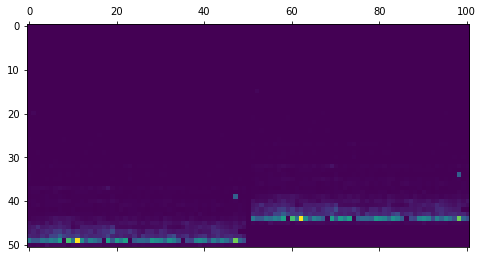

In [74]:
before = my_series.T
after = my_series_sort2
separator = np.array([[ 0 ] * 51]).T
plt.matshow(np.hstack((before, separator, after)), interpolation=None, aspect='auto')
plt.show()

In [77]:
from sklearn.metrics.pairwise import euclidean_distances
euclidean_distances([[0,6]], [[1,5]])

array([[ 1.41421356]])